In [1]:
!pip install pytorch-lightning
!pip install torchmetrics

In [2]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import os

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

# Data loading for Pascal VOC 2007
class PascalVOC2007DataModule(pl.LightningDataModule):
    def setup(self, stage):
        # download
        os.system('wget -nc https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar')
        os.system('wget -nc https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar')
        # unpack
        os.system('tar --skip-old-files -xf VOCtrainval_06-Nov-2007.tar')
        os.system('tar --skip-old-files -xf VOCtest_06-Nov-2007.tar')

        img_transform = transforms.Compose([ 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                    transforms.CenterCrop((2*2*2*2 * 23, 2*2*2*2 * 31))
                                    ])

        seg_mask_transform = transforms.Compose([
                                        transforms.Lambda(lambda x : torch.from_numpy(np.array(x)).long()),
                                        transforms.CenterCrop((2*2*2*2 * 23, 2*2*2*2 * 31))
                                        ])

        self.train_dataset = torchvision.datasets.VOCSegmentation(root='./', 
                                               year = '2007', 
                                               image_set = 'train',
                                               transform=img_transform, 
                                               target_transform=seg_mask_transform, 
                                               download = False)

        self.val_dataset = torchvision.datasets.VOCSegmentation(root='./', 
                                               year = '2007', 
                                               image_set = 'val',     
                                               transform=img_transform, 
                                               target_transform=seg_mask_transform, 
                                               download = False)

        self.test_dataset = torchvision.datasets.VOCSegmentation(root='./', 
                                               year = '2007', 
                                               image_set = 'test',     
                                               transform=img_transform, 
                                               target_transform=seg_mask_transform, 
                                               download = False)

        # for testing
        # mask = list(range(2))
        # self.train_dataset = torch.utils.data.Subset(self.train_dataset, mask)
        # self.val_dataset = torch.utils.data.Subset(self.val_dataset, mask)
        # self.test_dataset = torch.utils.data.Subset(self.test_dataset, mask)


    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=8)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,
                                           batch_size=32,
                                           shuffle=False,
                                           num_workers=8)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,
                                           batch_size=32,
                                           shuffle=False,
                                           num_workers=8)


Using device: cuda


## Exercise 1
The U-net works well for segmentation task as it utilizes cropped feature maps from the contracting path in the expanding path. Higher resolution features from the contracting path are also considered with the upsampled output in the expansive path in order to localize. This information enables successive layers to learn to gather more precise output.

Retaining information for localization could be considered as an important aspect of vision tasks. Using copied feature map from contracting path on expanding path to utilize both low dimensional and high dimensional image seems to be a good solution.

We believe that the model architecture which combines contracting path's information to expanding path, and the proper data augmentation enables the Unet to work well.
However, extensive augmentation like in the paper could be considered for further study. Especially the random elastic deformation conducted in the paper seems to be more suitable for the medical domain as it resembles common variation in tissue rather than variations in more generic images(e.g.photo of a dog).

In [3]:
# Exercise 1 (5 points):
# Read the U-Net paper by Ronneberger et al. 
# - Why do the authors state that the U-Net works good for segmentation.
# - Do you think their argumentation  makes sense?
# - What are your arguments that the U-Net works well?
#
# Exercise 2 (20 points):
# Implement a U-Net with the help of the following classes:
# 1) Block: conv -> relu -> conv. The first convolution maps input channel to output channel. 
#           Dimensions are to be retained, use filter size of 3.
#           For better convergence use Batch-norm after each ReLU.
# 2) Encoder: Compose multiple blocks and downsample between blocks by factor of 2 with max-pooling
# 3) Decoder: Compose multiple transpose convolutions and convolutions blocks that 
#             (i) upsample the input from the previous layer through transpose convolutions
#             (ii) concatenate the upsampled features with the corresponding layer from the encoder
#             (iii) pass it through a convolution block
# 4) UNet: Arrange encoder and decoder blocks into an U-Net. Add final 1x1 convolution to produce pixel-wise predictions.
# Note:
# - We do not completely follow the original U-Net architecture which slighly reduced dimensions by using convolutions without padding. Input and output dimensions should stay same.
# - We use pytorch lightning for the training. It might be good to acquaint yourself with the framework.
#
# Exercise 3:
# Log train loss, train accuracy, train mean IoU (also called Jaccard index), validation accuracy and and validation mean IoU.
# To this end you can use the tensorboard graphs and write a short report.
# 
# Extra exercise: (you can earn extra points, but it is not required, 10 points)
# Improve the U-Net by using augmentations, better training, more involved U-Net blocks (see the network components from Lecture 5) or better loss.
# The highest obtained mean IoU (with proof) will get a honorable mention.
class Block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(ch_out)
        self.conv2  = nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.conv2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, chn):
        super().__init__()
        self.ch_n = np.size(list(chn))
        self.blocks = nn.ModuleList([Block(chn[idx], chn[idx+1]) for idx in range(self.ch_n-1)])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        block_output = []
        for block in self.blocks:
            x = block(x)
            block_output.append(x)
            x = self.pool(x)
        return block_output

class Decoder(nn.Module):
    def __init__(self, chn):
        super().__init__()
        chn_rv = list(chn)[::-1]
        self.ch_n = np.size(list(chn_rv))
        self.upsampling = nn.ModuleList([nn.ConvTranspose2d(chn_rv[idx], chn_rv[idx+1], kernel_size=2, stride=2) for idx in range(self.ch_n-1)])
        self.blocks_rv = nn.ModuleList([Block(chn_rv[idx], chn_rv[idx+1]) for idx in range(self.ch_n-1)])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, encoder_output):
        for i in range(self.ch_n-2):
            x = self.upsampling[i](x)
            # print("after upsampling ", i, x.shape)
            _, _, H, W = x.shape
            
            encoder_output_crop = torchvision.transforms.CenterCrop([H, W])(encoder_output[i])
            # print("cropped size ", encoder_output_crop.shape)

            x = torch.cat([x, encoder_output_crop], dim=1)
            # print("concat size: ", x.shape)

            x = self.blocks_rv[i](x)
        return x

In [5]:
class UNet(pl.LightningModule):

    def __init__(self, chn=(3,64,128,256,512,1024), num_class=21):
        super().__init__()
        self.num_class = num_class
        self.learning_rate = 0.01#1e-3

        self.train_pixel_acc = torchmetrics.classification.MulticlassAccuracy( num_classes=21, ignore_index=255, average='weighted')
        self.train_J = torchmetrics.classification.MulticlassJaccardIndex(num_classes = 21, ignore_index = 255, average='weighted')

        self.val_pixel_acc = torchmetrics.classification.MulticlassAccuracy(num_classes = 21, ignore_index = 255, average='weighted')
        self.val_J = torchmetrics.classification.MulticlassJaccardIndex(num_classes = 21, ignore_index = 255, average='weighted')

        self.test_pixel_acc = torchmetrics.classification.MulticlassAccuracy(num_classes = 21, ignore_index = 255, average='weighted')
        self.test_J = torchmetrics.classification.MulticlassJaccardIndex(num_classes = 21, ignore_index = 255, average='weighted')

        # TODO: Define U-Net layers #
        # encoder
        self.encoder = Encoder(chn)
        # bottleneck
        self.decoder = Decoder(chn)
        # decoder
        self.conv = nn.Conv2d(chn[1], num_class, kernel_size=1)
        #############################

    def forward(self, x):
        # TODO: Define U-Net layers #
        encoder_output = self.encoder(x)
        encoder_rv_output = encoder_output[::-1]
        output = self.decoder(encoder_rv_output[0],encoder_rv_output[1:])
        output = self.conv(output)
        return output
        #############################

    def decode_segmap(self, prediction):
        label_colors = torch.tensor([(0, 0, 0),  # 0=background
                    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                    (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
                    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
        r = torch.zeros_like(prediction, dtype=torch.uint8)
        g = torch.zeros_like(prediction, dtype=torch.uint8)
        b = torch.zeros_like(prediction, dtype=torch.uint8)
        for l in range(0, self.num_class):
            idx = prediction == l
            r[idx] = label_colors[l, 0]
            g[idx] = label_colors[l, 1]
            b[idx] = label_colors[l, 2]
        rgb = torch.stack([r, g, b], axis=1)
        return rgb

    def training_step(self, train_batch, batch_idx):
        images, seg_mask = train_batch

        # Forward pass
        outputs = model(images)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

        loss = criterion(outputs, seg_mask)
        self.log('train_loss', loss)

        # train acc and mIoU
        pred_seg_mask = torch.argmax(outputs, 1)
        self.train_pixel_acc(pred_seg_mask, seg_mask)
        self.train_J(pred_seg_mask, seg_mask)

        self.log('train_acc', self.train_pixel_acc, on_step=False, on_epoch=True)
        self.log('train_mIoU', self.train_J, on_step=False, on_epoch=True)

        # visualize CNN prediction
        if batch_idx == 2:
            inv_normalize = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                std=[1/0.229, 1/0.224, 1/0.255]
                )
            pred = torch.argmax(outputs,1)
            pred_seg_map = self.decode_segmap(pred)
            gt_seg_map = self.decode_segmap(seg_mask)

            img_grid = torchvision.utils.make_grid(
                torch.cat((inv_normalize(images.float()), gt_seg_map, pred_seg_map), dim=0), 
                nrow=2)
            self.logger.experiment.add_image('train_pred', img_grid.float(), self.current_epoch)

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, seg_mask = val_batch
        outputs = model(images)
        pred_seg_mask = torch.argmax(outputs, 1)

        # pixel-wise accuracy
        self.val_pixel_acc(pred_seg_mask, seg_mask)

        # the Jaccard index (mean IoU)
        self.val_J(pred_seg_mask, seg_mask)

        self.log('val_acc', self.val_pixel_acc, on_step=False, on_epoch=True)
        self.log('val_mIoU', self.val_J, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        images, seg_mask = batch
        outputs = model(images)
        pred_seg_mask = torch.argmax(outputs, 1)

        self.test_pixel_acc(pred_seg_mask, seg_mask)
        self.test_J(pred_seg_mask, seg_mask)

        self.log("test_acc", self.test_pixel_acc)
        self.log("test_mIoU", self.test_J)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return opt


In [6]:

data_module = PascalVOC2007DataModule()

# train
model = UNet()
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=150, log_every_n_steps=1, callbacks=[lr_monitor], auto_lr_find=True)
#trainer.tune(model, datamodule=data_module)
trainer.fit(model, data_module)
trainer.test(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
File ‘VOCtrainval_06-Nov-2007.tar’ already there; not retrieving.

File ‘VOCtest_06-Nov-2007.tar’ already there; not retrieving.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name            | Type                   | Params
-----------------------------------------------------------
0 | train_pixel_acc | MulticlassAccuracy     | 0     
1 | train_J         | MulticlassJaccardIndex | 0     
2 | val_pixel_acc   | MulticlassAccuracy     | 0     
3 | val_J           | MulticlassJaccardIndex | 0     
4 | test_pixel_acc  | MulticlassAccuracy     | 0     
5 | test_J          | MulticlassJaccardIndex | 0     
6 | encoder         | Encoder                | 18.8 M
7 | decoder         | Decoder                | 12.2 M
8 | conv            | Conv2d                 | 1.4 K 
-----------------------------------------------------------
3

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
File ‘VOCtrainval_06-Nov-2007.tar’ already there; not retrieving.

File ‘VOCtest_06-Nov-2007.tar’ already there; not retrieving.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7291735410690308
        test_mIoU           0.5692635774612427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7291735410690308, 'test_mIoU': 0.5692635774612427}]

In [2]:
%load_ext tensorboard

from our model, test accuracy of 0.729 and test mean IoU of 0.569 are achieved. 

In [4]:
#tensorboard result for main Unet implementation
%tensorboard --logdir 'lightning_logs_original' --bind_all
#https://tensorboard.dev/experiment/86jlvRyPRg6MRhMy6x0Lfw/

In [22]:
#Extra
#Tensorboard for Unet experiment. Data augmentation

%tensorboard --logdir 'lightning_logs_aug/' --bind_all
#https://tensorboard.dev/experiment/LdBFz7KaSWKwC3X5ZRHQgg/

Reusing TensorBoard on port 6007 (pid 69928), started 1:10:38 ago. (Use '!kill 69928' to kill it.)

from our experiment with data augmentation, 
test accuracy of 0.704 and test mean IoU of 0.538 are achieved.
ColorJitter and random horizontal flip have been implemented.
However we could not reach the better test results.

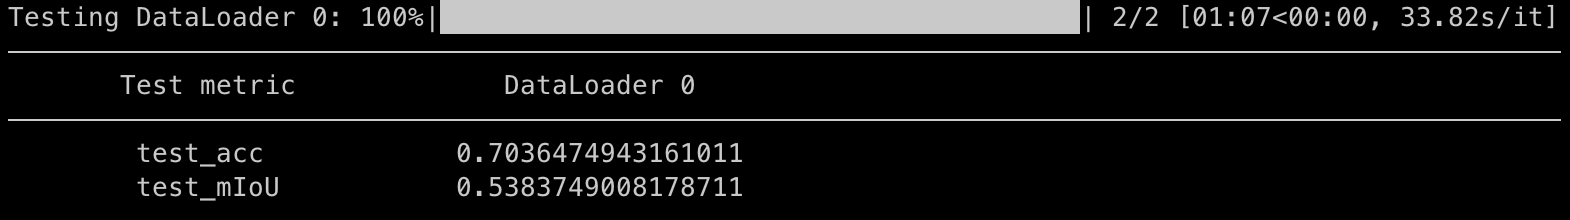

In [15]:
from IPython import display
display.Image('result_aug.png')